In [28]:
import torch
import matplotlib.pyplot as plt
import requests
import numpy as np
from   torch.nn import functional as F
from   matplotlib.pyplot import imshow
from   torch.nn import ReLU
from   torch.autograd import Variable
from   torchvision import models
from   PIL import Image

In [29]:
class SensitivityHeatmap():
    
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.stored_grad = False
        # Hook the first layer to get the gradient
        self.hook_first_layers()
        # Hook the ReLU layers
        self.hook_relus()
        
    def hook_first_layers(self):
    
            def hook_grad_input(module, inputs, outputs):
                
                if not self.stored_grad:
                    # register_backward_hook(module,grad_in,grad_out)
                        # grad_in: Gradients of the target class wrt. the input of the current layer
                        # grad_out: Gradients of the target class wrt. the output of the current layer
                        #           = grad_in*(gradient of layer output wrt. layer input)
                    module.register_backward_hook(store_grad)
                    # Register hook to the first layer only for the first time -> first layer
                    self.stored_grad = True
    
            def store_grad(module, grad_in, grad_out):
                # store the gradients of the target class wrt. the first layer in self.gradients
                self.gradients = grad_in[0]
    
            for module in self.model.modules():
                # register_forward_hook(moduel,input,output)
                    # input: current layer's input; output: current layer's output
                module.register_forward_hook(hook_grad_input)
                
    
    def hook_relus(self):
        
        def relu_hook_function(module, grad_in, grad_out):
            
            # grad_in: The gradients of the target class wrt. the input of the current layer
            # [0] to get rid of the first channel
            # Then grad_in[0] are returned and backpropagated to the next (early) layer.
            return (grad_in[0],)
        
        # Loop through layers, hook up ReLUs with relu_hook_function
        for module in self.model.modules():
            # Find the ReLu modules in the model.
            # The isinstance() function checks if the moduel is an instance or subclass of ReLU.
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_hook_function)
                

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Creat a empty tenor with the same size as model_output
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        # Get the target class for backpropagate
        one_hot_output[0][target_class] = 1
        # Backward Pass. 
        # The model_output is non-scalar because it has 1000 elements,so the specifying 'gradient=one_hot_output' 
        # is used to select out the requirted target class from them and then caculate the gradients.
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


In [30]:
def convert_to_grayscale(im_as_arr):
    
    # Sum up the absolute values of the pixels in each channel
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0) # axis: Axis along which a sum is performed.
    # Choose the 99-th percentile of the data 'grayscale_im' as the maximum value
    # Alternative: im_max = np.max(grayscale_im) but the results are less clear
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    # Make sure the values in the array are limited in the interval [0, 1]. 
    # Values smaller than 0 become 0, and values larger than 1 become 1.
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    # Insert a new axis that will appear at the first axis position in the expanded array shape to match the dimension.
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

In [31]:
def preprocess_image(pil_im, resize_im=True):
    
    # mean and std list for channels (Imagenet dataset)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)
    # modify the array’s data-type to float 32
    im_as_arr = np.float32(pil_im)
    
    # Normalize the channels
    im_as_arr /= 255

    im_as_arr = (im_as_arr - mean) / std

    # Permute the axes of the numpy array from (Height,Weight,channel) to (channel,Height,Weight)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  

    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable. By setting requires_grad=True, the tensors created by the torch.autograd.Variable class can form 
    # a backward graph that tracks every operations applied on them to calculate the gradients.
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [32]:
def get_example_params(example_index):

        # Input image list
        example_list = (('./input_images/0_RaceCar.jpg'),
                        ('./input_images/1_bicycle.jpg'),
                        ('./input_images/2_dog.jpg'),
                        ('./input_images/3_laptop.jpg'),
                        ('./input_images/4_CatDog.jpg'))
        #Get the path of the input image
        img_path = example_list[example_index]
        # Read image
        original_image = Image.open(img_path).convert('RGB')
        # Resize the input image
        original_image = original_image.resize((224, 224), Image.ANTIALIAS)
        # Process image
        prep_img = preprocess_image(original_image)
        # Define model. 
        # The following models are supported: Alexnet, Squeezenet, Vgg, Resnet and Densenet 
        # Set the pretrained = False to get a correspoding untrained model
        pretrained_model = models.vgg19(pretrained=True)
        # Put model in evaluation mode
        pretrained_model.eval()
        # Convert to Pytorch variable
        input_var = Variable(prep_img, requires_grad=True)
        predictions = pretrained_model(input_var)
        # Select the class with the maximum prediction value as the target class 
        target_class = torch.argmax(predictions, dim=1)
        # Convert Pytorch variable to numpy array
        # [0] to convent tensor to scalar
        target_class = target_class.item() #numpy()[0]
        # For a particular class of interest, set its index in the ImageNet dataset as the target_class.Range: 0-999.
        # For example:
#         target_class = 452 
                               
        return (original_image,
                prep_img,
                target_class,
                pretrained_model)

The Sensitivity Heatmap for class: racer is generated as following.


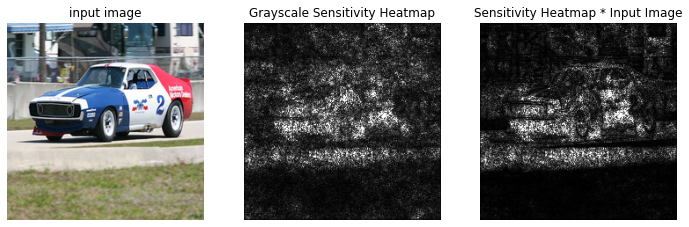

In [33]:
if __name__ == '__main__':
    
    # Change the input image by inputing the serial number of the desired images
    target_example = 0 # race car
    
    (original_image, prep_img, target_class, pretrained_model) = get_example_params(target_example)
    
    # load the labels of the Imagnenet dataset
    LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json' # 30.04.2022 old url is broken.

    r = requests.get(LABELS_URL)

    try:
      data = r.json()
    except ValueError:
      print("Response content is not valid JSON")
    
    # download the imagenet category list
    classes = {int(key):value for (key, value)
          in data.items()}
    
    # SensitivityHeatmap
    SH = SensitivityHeatmap(pretrained_model)
    
    # Get gradients
    vanilla_grads = SH.generate_gradients(prep_img, target_class)
    
    print('The Sensitivity Heatmap for class: {} is generated as following.'.format(classes[target_class][1]))
               
    # Plot
    fig = plt.figure(figsize=(12, 4))
    # Plot the input image
    ax = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(original_image)
    plt.axis('off')
    ax.set_title('input image')
    # Plot the grayscale sensitivity heatmap
    ax = fig.add_subplot(1, 3, 2)
    grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
    # Limit the array's range to the interval 0-1
    grayscale_vanilla_grads = (grayscale_vanilla_grads - grayscale_vanilla_grads.min())/grayscale_vanilla_grads.max()
    # transpose function:permute the axes of the array to correctly show the image
    # The size of grayscale_vanilla_grads changes from (1,244,244) to (224,224,1) after the transpose function
    imgplot = plt.imshow(grayscale_vanilla_grads.transpose(1,2,0),cmap="gray")
    plt.axis('off')
    ax.set_title('Grayscale Sensitivity Heatmap')
    # Plot the sensitivity heatmap*input
    ax = fig.add_subplot(1, 3, 3)
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad i.e., 
    # it detaches the output from the computational graph.[0] to get rid of the first channel
    grad_times_image = vanilla_grads * prep_img.detach().numpy()[0]
    # Convert to grayscale
    grad_times_image = convert_to_grayscale(grad_times_image)
    # Limit the array's range to the interval 0-1
    grad_times_image = (grad_times_image - grad_times_image.min())/ grad_times_image.max()
    # The size of grad_times_image changes from (1,244,244) to (224,224,1) after the transpose function
    imgplot = plt.imshow(grad_times_image.transpose(1,2,0),cmap="gray")
    plt.axis('off')
    ax.set_title('Sensitivity Heatmap * Input Image')
